In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/chest-xray-pneumonia/chest_xray'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/per

In [2]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
from collections import Counter
# data_dir = os.path.join(os.getcwd(), "drive", "MyDrive", "pneumonia")
data_dir = os.path.join("/kaggle/input/chest-xray-pneumonia/chest_xray")
print(f"Our data directory is {data_dir}")
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")
val_dir = os.path.join(data_dir, "val")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset =ImageFolder(root=train_dir, transform=transform)
val_dataset = ImageFolder(root=val_dir, transform=transform)
test_dataset =ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Our data directory is /kaggle/input/chest-xray-pneumonia/chest_xray


In [3]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
from collections import Counter

# Data paths for Kaggle dataset structure
data_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")
val_dir = os.path.join(data_dir, "val")

# Data transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Dataset and loaders
train_dataset = ImageFolder(root=train_dir, transform=transform)
val_dataset = ImageFolder(root=val_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = train_dataset.classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# 1. Show sample images
def show_sample_images(dataset, class_names, n=5):
    fig, axs = plt.subplots(len(class_names), n, figsize=(n*2, len(class_names)*2))
    axs = axs.reshape(len(class_names), n)
    class_indices = {cls: [] for cls in class_names}

    for i, (_, label) in enumerate(dataset):
        class_name = class_names[label]
        if len(class_indices[class_name]) < n:
            class_indices[class_name].append(i)
        if all(len(v) >= n for v in class_indices.values()):
            break

    for row, cls in enumerate(class_names):
        for col in range(n):
            img, _ = dataset[class_indices[cls][col]]
            axs[row][col].imshow(img.permute(1, 2, 0))
            axs[row][col].axis('off')
            if col == 0:
                axs[row][col].set_title(cls)
    plt.tight_layout()
    plt.show()

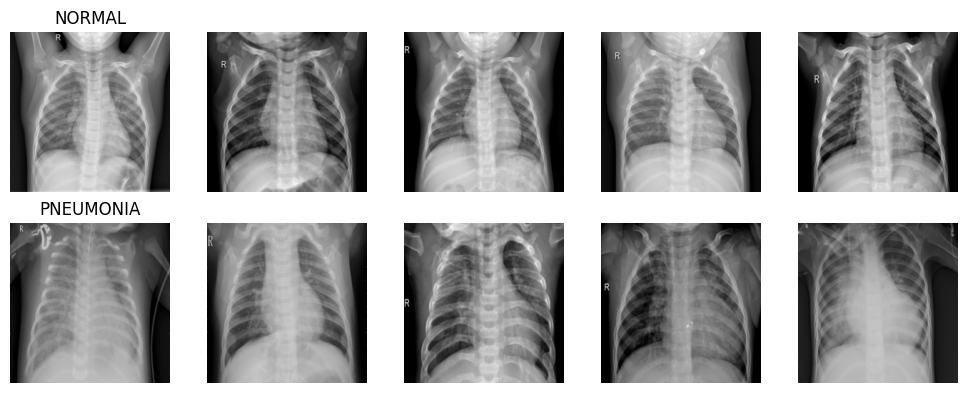

In [5]:
 show_sample_images(train_dataset, class_names)


In [6]:
# 2. Class distribution
def plot_class_distribution(dataset, class_names):
    labels = [label for _, label in dataset]
    class_counts = Counter(labels)
    plt.bar(class_names, [class_counts[i] for i in range(len(class_names))])
    plt.title("Class Distribution")
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.show()

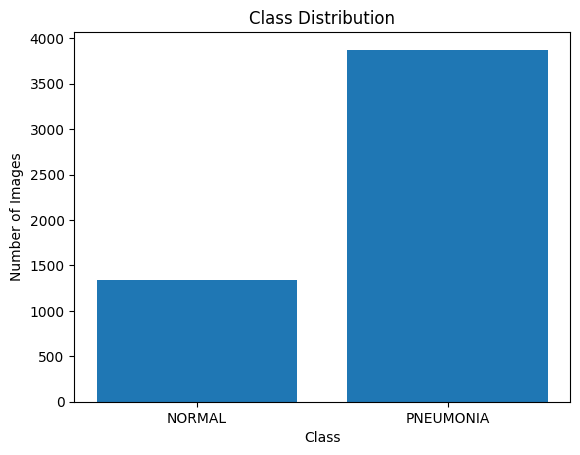

In [7]:
 plot_class_distribution(train_dataset, class_names)


In [8]:
# 3. RGB histogram for a sample image
def plot_image_histogram(dataset, index=0):
    img, _ = dataset[index]
    img_np = img.permute(1, 2, 0).numpy()
    plt.figure(figsize=(12, 4))
    for i, color in enumerate(['Red', 'Green', 'Blue']):
        plt.subplot(1, 3, i + 1)
        plt.hist(img_np[:, :, i].ravel(), bins=256, color=color.lower())
        plt.title(f'{color} Channel Histogram')
    plt.tight_layout()
    plt.show()

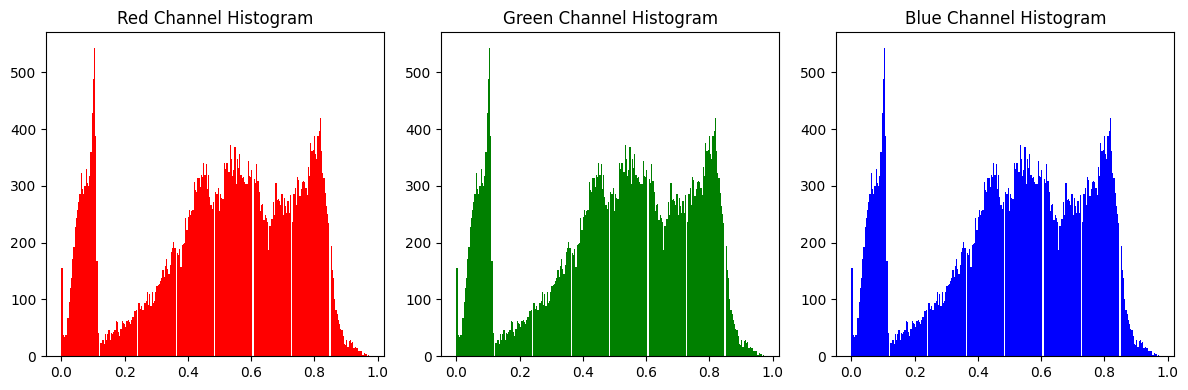

In [9]:
 plot_image_histogram(train_dataset, index=0)


In [10]:
import torch
import torch.nn as nn
class CNNWithGELU(nn.Module):
    def __init__(self, num_classes=1):
        super(CNNWithGELU, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(3,64,kernel_size=7,stride=2,padding=3,bias=False),
            nn.BatchNorm2d(64),
            nn.GELU(),
            nn.MaxPool2d(kernel_size=3,stride=2,padding=1))
        self.layer2 = nn.Sequential(nn.Conv2d(64, 128,kernel_size=3,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(128),
            nn.GELU())
        self.layer3 = nn.Sequential(nn.Conv2d(128,256,kernel_size=3,stride=2,padding=1,bias=False),
                                    nn.BatchNorm2d(256),
                                    nn.GELU())
        self.layer4 = nn.Sequential(nn.Conv2d(256,512,kernel_size=3,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(512),
            nn.GELU())
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [11]:
model=CNNWithGELU()

def apply_gradcam(model, image_tensor, target_layer):
    model.eval()
    gradients = []
    activations = []

    def save_gradients(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    def save_activations(module, input, output):
        activations.append(output)

    handle_fw = target_layer.register_forward_hook(save_activations)
    handle_bw = target_layer.register_backward_hook(save_gradients)

    image_tensor = image_tensor.unsqueeze(0).to(device)
    output = model(image_tensor)
    class_idx = output.argmax(dim=1).item() if output.shape[1] > 1 else 0

    model.zero_grad()
    loss = output[0][0] if output.shape[1] == 1 else output[0, class_idx]
    loss.backward()

    gradients_ = gradients[0]
    activations_ = activations[0]

    pooled_grads = torch.mean(gradients_, dim=[0, 2, 3])
    for i in range(activations_.shape[1]):
        activations_[:, i, :, :] *= pooled_grads[i]
    heatmap = torch.mean(activations_, dim=1).squeeze()
    heatmap = torch.relu(heatmap)
    heatmap /= torch.max(heatmap)

    img_np = image_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    heatmap = heatmap.detach().cpu().numpy()
    heatmap = np.maximum(heatmap, 0)  # remove negative values
    heatmap = heatmap / (heatmap.max() + 1e-8)  # normalize safely
    heatmap = cv2.resize(heatmap, (img_np.shape[1], img_np.shape[0]))
    heatmap = np.uint8(255 * heatmap)

    heatmap_colored = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted((img_np * 255).astype(np.uint8), 0.6, heatmap_colored, 0.4, 0)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(img_np)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Grad-CAM")
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    handle_fw.remove()
    handle_bw.remove()


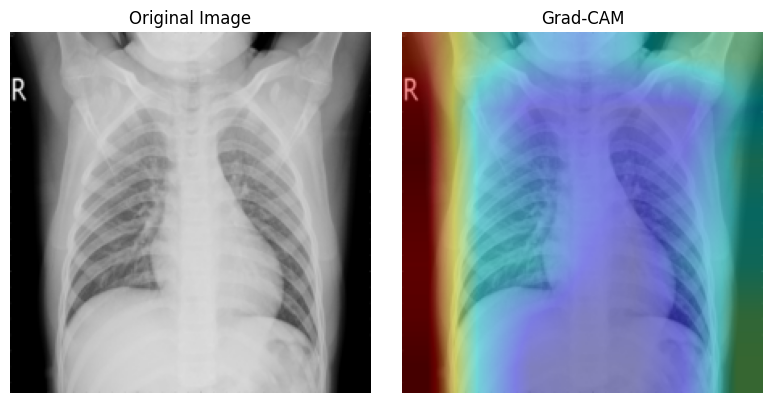

In [12]:
sample_img, _ = val_dataset[0]
sample_img = sample_img.to(device)  # move image to GPU
model = model.to(device)            # ensure model is on same device
apply_gradcam(model, sample_img, model.layer4[2])


In [13]:
def visualize_feature_maps(model, image_tensor, layer, num_maps=16):
    """
    Visualizes feature maps from a specific layer of the model.
    
    :param model: CNN model
    :param image_tensor: input image (C, H, W)
    :param layer: layer from which to extract activations (e.g., model.layer1)
    :param num_maps: number of feature maps to display
    """
    model.eval()
    activation = []

    def hook_fn(module, input, output):
        activation.append(output)

    # Register hook to capture outputs
    handle = layer.register_forward_hook(hook_fn)

    # Forward pass
    image_tensor = image_tensor.unsqueeze(0).to(device)
    _ = model(image_tensor)

    # Get the activation maps
    act_maps = activation[0].squeeze().detach().cpu()

    # Plot
    num_maps = min(num_maps, act_maps.shape[0])
    cols = 4
    rows = (num_maps + cols - 1) // cols
    plt.figure(figsize=(cols * 3, rows * 3))

    for i in range(num_maps):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(act_maps[i], cmap='viridis')
        plt.axis('off')
        plt.title(f"Map {i+1}")

    plt.suptitle(f"Feature Maps from {layer}", fontsize=14)
    plt.tight_layout()
    plt.show()

    handle.remove()


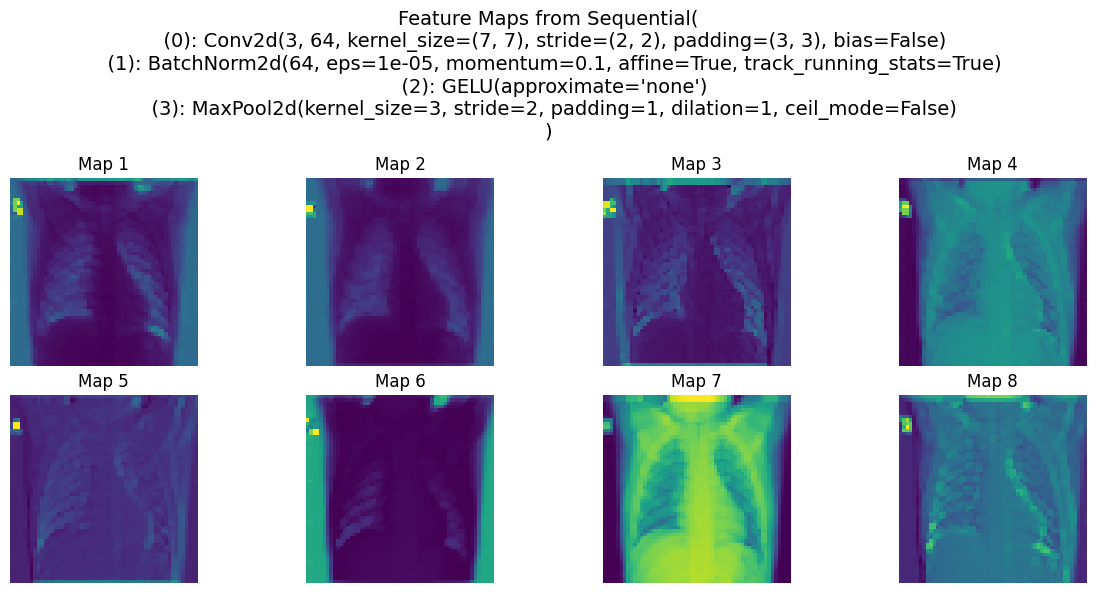

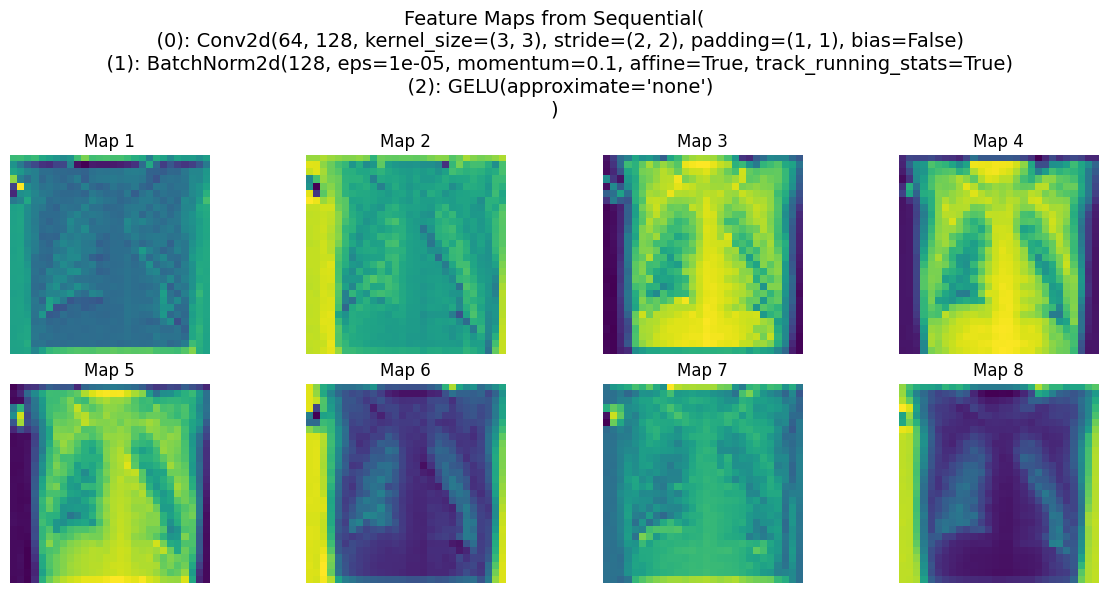

In [14]:
sample_img, _ = val_dataset[0]
visualize_feature_maps(model, sample_img, model.layer1, num_maps=8)  # Layer1 activations
visualize_feature_maps(model, sample_img, model.layer2, num_maps=8)  # Layer2 activations


In [15]:
model = CNNWithGELU(num_classes=1).to(device)
from torchsummary import summary
summary(model, input_size=(3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              GELU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 128, 28, 28]          73,728
       BatchNorm2d-6          [-1, 128, 28, 28]             256
              GELU-7          [-1, 128, 28, 28]               0
            Conv2d-8          [-1, 256, 14, 14]         294,912
       BatchNorm2d-9          [-1, 256, 14, 14]             512
             GELU-10          [-1, 256, 14, 14]               0
           Conv2d-11            [-1, 512, 7, 7]       1,179,648
      BatchNorm2d-12            [-1, 512, 7, 7]           1,024
             GELU-13            [-1, 512, 7, 7]               0
AdaptiveAvgPool2d-14            [-1, 51